In [8]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [9]:
#change the tickers here according to what's in the portfolio
tickers = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','ETR','CCEP','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [10]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LHX     1259 non-null   float64
 1   ODFL    1259 non-null   float64
 2   SAIA    1259 non-null   float64
 3   AXP     1259 non-null   float64
 4   TROW    1259 non-null   float64
 5   CG      1259 non-null   float64
 6   CSWC    1259 non-null   float64
 7   CBRE    1259 non-null   float64
 8   SBAC    1259 non-null   float64
 9   ETR     1259 non-null   float64
 10  CCEP    1259 non-null   float64
 11  ^FVX    1259 non-null   float64
dtypes: float64(12)
memory usage: 127.9 KB


## Function that saves dataframe to CSV

In [11]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [12]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Adj Close']
    save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [13]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [14]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [15]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [16]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [17]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [18]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [19]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [20]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','ETR','CCEP','^FVX']

#add in the weightage of stocks
port_shares = [0.0064644,0.0304168,0.0031188,0.0014604,0.0109772,0.0159804,0.011582,0.0126108,0.0273892,0.04,0.04,0.8]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,ETR,CCEP,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,
2017-01-03,0.606126,1.724261,0.140034,0.101909,0.724900,0.196330,0.114055,0.398123,2.851279,2.371445,1.101126,1.5552,11.884788,NaN
2017-01-04,0.609431,1.731414,0.140502,0.103579,0.735701,0.201994,0.116847,0.404554,2.855332,2.381848,1.108848,1.5576,11.947651,0.005289
2017-01-05,0.610198,1.710949,0.137071,0.102302,0.729966,0.205140,0.116707,0.401150,2.817506,2.373396,1.121485,1.4904,11.816270,-0.010996
2017-01-06,0.616925,1.710750,0.139972,0.102506,0.722797,0.209545,0.115172,0.393457,2.796972,2.381198,1.120783,1.5376,11.847677,0.002658
2017-01-09,0.602704,1.701412,0.137539,0.103036,0.696130,0.210174,0.116707,0.392574,2.782652,2.311297,1.121836,1.5048,11.680861,-0.014080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.353698,10.805881,1.038716,0.239474,2.187976,0.897299,0.290592,1.359318,10.499923,4.393032,2.224000,1.0016,36.291510,0.018007
2021-12-28,1.365476,10.837484,1.029797,0.239503,2.188963,0.886433,0.289897,1.358435,10.537447,4.435048,2.230000,0.9960,36.394484,0.002837
2021-12-29,1.366827,10.964201,1.046077,0.238658,2.168436,0.868854,0.288392,1.369281,10.543473,4.458830,2.246400,1.0352,36.594629,0.005499


## Get old data for portfolio

In [21]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,ETR,CCEP,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,
2017-01-03,0.606126,1.724261,0.140034,0.101909,0.724900,0.196330,0.114055,0.398123,2.851279,2.371445,1.101126,1.5552,11.884788,NaN
2017-01-04,0.609431,1.731414,0.140502,0.103579,0.735701,0.201994,0.116847,0.404554,2.855332,2.381848,1.108848,1.5576,11.947651,0.005289
2017-01-05,0.610198,1.710949,0.137071,0.102302,0.729966,0.205140,0.116707,0.401150,2.817506,2.373396,1.121485,1.4904,11.816270,-0.010996
2017-01-06,0.616925,1.710750,0.139972,0.102506,0.722797,0.209545,0.115172,0.393457,2.796972,2.381198,1.120783,1.5376,11.847677,0.002658
2017-01-09,0.602704,1.701412,0.137539,0.103036,0.696130,0.210174,0.116707,0.392574,2.782652,2.311297,1.121836,1.5048,11.680861,-0.014080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.353698,10.805881,1.038716,0.239474,2.187976,0.897299,0.290592,1.359318,10.499923,4.393032,2.224000,1.0016,36.291510,0.018007
2021-12-28,1.365476,10.837484,1.029797,0.239503,2.188963,0.886433,0.289897,1.358435,10.537447,4.435048,2.230000,0.9960,36.394484,0.002837
2021-12-29,1.366827,10.964201,1.046077,0.238658,2.168436,0.868854,0.288392,1.369281,10.543473,4.458830,2.246400,1.0352,36.594629,0.005499


## Forecasting

In [22]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [23]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [24]:
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,ETR,CCEP,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,
2017-01-03,0.606126,1.724261,0.140034,0.101909,0.724900,0.196330,0.114055,0.398123,2.851279,2.371445,1.101126,1.5552,11.884788,NaN
2017-01-04,0.609431,1.731414,0.140502,0.103579,0.735701,0.201994,0.116847,0.404554,2.855332,2.381848,1.108848,1.5576,11.947651,0.005289
2017-01-05,0.610198,1.710949,0.137071,0.102302,0.729966,0.205140,0.116707,0.401150,2.817506,2.373396,1.121485,1.4904,11.816270,-0.010996
2017-01-06,0.616925,1.710750,0.139972,0.102506,0.722797,0.209545,0.115172,0.393457,2.796972,2.381198,1.120783,1.5376,11.847677,0.002658
2017-01-07,0.616925,1.710750,0.139972,0.102506,0.722797,0.209545,0.115172,0.393457,2.796972,2.381198,1.120783,1.5376,11.847677,0.002658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.353698,10.805881,1.038716,0.239474,2.187976,0.897299,0.290592,1.359318,10.499923,4.393032,2.224000,1.0016,36.291510,0.018007
2021-12-28,1.365476,10.837484,1.029797,0.239503,2.188963,0.886433,0.289897,1.358435,10.537447,4.435048,2.230000,0.9960,36.394484,0.002837
2021-12-29,1.366827,10.964201,1.046077,0.238658,2.168436,0.868854,0.288392,1.369281,10.543473,4.458830,2.246400,1.0352,36.594629,0.005499


In [25]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','ETR','CCEP','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [26]:
tot_port_df

,Total
Date,
2017-01-03,11.884788
2017-01-04,11.947651
2017-01-05,11.816270
2017-01-06,11.847677
2017-01-07,11.847677
...,...
2021-12-27,36.291510
2021-12-28,36.394484
2021-12-29,36.594629


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Observations : 1824


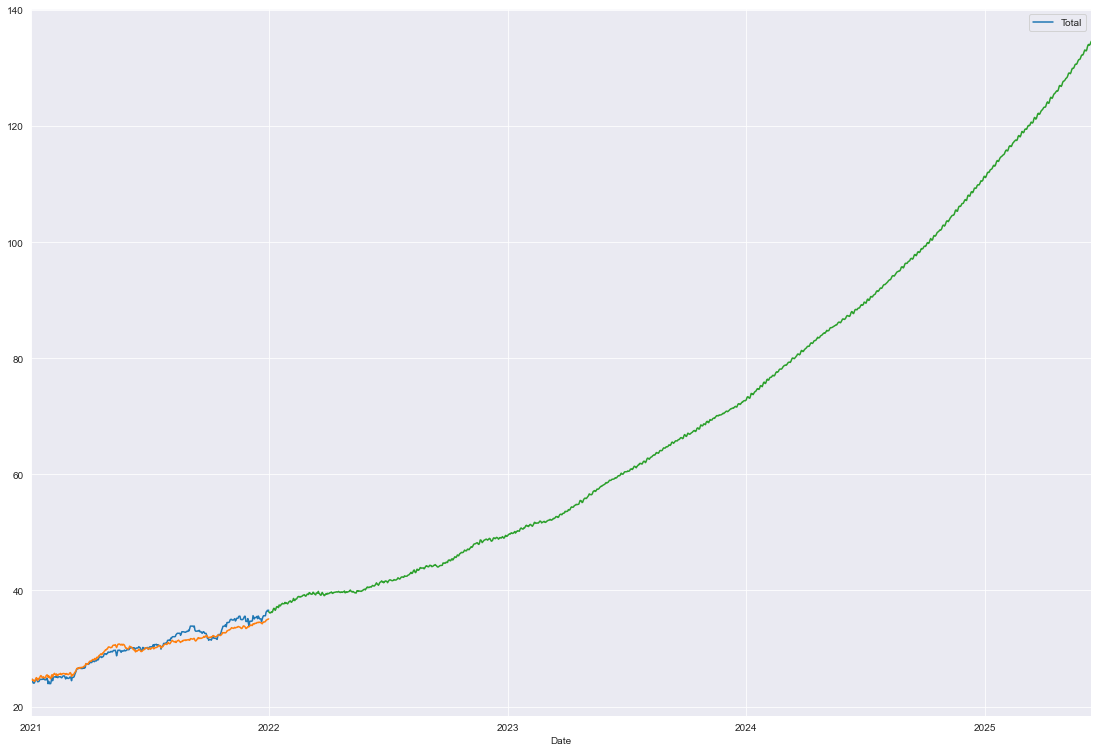

In [27]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [28]:
forecast

2021-12-31     36.361594
2022-01-01     36.206597
2022-01-02     36.119030
2022-01-03     36.182662
2022-01-04     36.302927
                 ...    
2025-06-09    134.019398
2025-06-10    133.881636
2025-06-11    133.990276
2025-06-12    134.263451
2025-06-13    134.570968
Freq: D, Length: 1261, dtype: float64

In [29]:
forecast_df = pd.DataFrame(forecast)

In [30]:
forecast_df

,0
2021-12-31,36.361594
2022-01-01,36.206597
2022-01-02,36.119030
2022-01-03,36.182662
2022-01-04,36.302927
...,...
2025-06-09,134.019398
2025-06-10,133.881636
2025-06-11,133.990276
2025-06-12,134.263451


In [31]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [32]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.004263
2022-01-02,-0.006671
2022-01-03,-0.004921
2022-01-04,-0.001613
...,...
2025-06-09,2.685740
2025-06-10,2.681952
2025-06-11,2.684940
2025-06-12,2.692452


In [33]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1/5))-1

print(annualized_return*100)

                    0
2025-06-13  29.915717
